In [136]:
%matplotlib inline
#imports
import os
import random
import pandas as pd
import numpy as np
import cv2
import shutil
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
#model = SentenceTransformer('bert-base-nli-mean-tokens')

In [268]:
dataPath = "../Data/MET/"
GANDataPath = "../Data/CelebA/img_align_celeba"
data = pd.read_csv("../Data/MET/works_downloaded.csv", sep="\t")

In [269]:
data["Tags"].fillna("", inplace=True)

In [270]:
data["TagList"] = data["Tags"].apply(lambda x : x.lower().split("|"))

In [271]:
data["TagList"].tolist()

[['girls', 'portraits'],
 ['fruit', 'leaves'],
 ['animals', 'pastoral', 'trees', 'evening'],
 ['shakespeare', 'kings', 'men', 'women', 'dogs'],
 ['houses', 'farms', 'men', 'cows', 'hills'],
 ['interiors', 'men', 'portraits', 'chemistry', 'working'],
 ['girls', 'flowers'],
 ['women'],
 ['women'],
 ['portraits', 'women'],
 ['men', 'portraits'],
 ['portraits', 'women'],
 ['men', 'portraits'],
 ['men', 'portraits'],
 ['boys', 'girls', 'women', 'playing', 'family', 'games'],
 ['houses', 'boys', 'girls', 'women', 'working'],
 ['animals', 'plants'],
 ['birds', 'cherries', 'boys', 'portraits'],
 ['men', 'portraits'],
 ['portraits', 'women'],
 ['portraits', 'women'],
 ['men', 'portraits'],
 ['landscapes', 'rivers', 'mountains'],
 ['men', 'women', 'waterfalls', 'landscapes', 'trees'],
 ['tents', 'horses', 'mountains', 'landscapes'],
 ['landscapes', 'mountains', 'dawn'],
 ['human figures', 'men', 'cats', 'rivers', 'boats'],
 ['portraits', 'women', 'sheep'],
 ['portraits', 'women'],
 ['portraits',

In [303]:
'''
Filter data for those matching some set of tags
'''
def get_file_list_for_tag(tags):
    filt = data["TagList"].apply(lambda x: np.any([tag in x for tag in tags]))
    return data[filt]

'''
Copy filtered files
'''
def copy_tagged(tagged, num):
    i = 0
    domCols = np.zeros((num, 3))
    for filename in tagged["Filename"].tolist():
        if len(os.listdir(GANDataPath)) < num:
            shutil.copy(os.path.join(dataPath, filename), os.path.join(GANDataPath, filename))
            domCols[i] = get_dom_col(dataPath, filename)
            i += 1
    np.savetxt(os.path.join(GANDataPath, "DomCols.txt"), domCols, fmt='%u')
            
        
'''
randomly pick an image
'''
def pick_img(dataPath, tagged):
    randFile = random.choice(tagged['Filename'].tolist())
    img = cv2.imread(os.path.join(dataPath, randFile))
    return img

'''
get image at an index
'''
def get_img(dataPath, tagged, i):
    file = tagged['Filename'].tolist()[i]
    img = cv2.imread(os.path.join(dataPath, file))
    return img

'''
Use numpy bincount to get the most common bgr color in the image
'''
def bincount(img):
    img2D = img.reshape(-1, img.shape[-1])
    col_range = (256, 256, 256) # generically : a2D.max(0)+1
    img1D = np.ravel_multi_index(img2D.T, col_range)
    return np.unravel_index(np.bincount(img1D).argmax(), col_range)

'''
Given a filename and a quantization factor, read in the corresponding image,
quantize it, fidn the dominant color of the 
'''
def get_dom_col(dataPath, imgname, quant=20):
    img = cv2.imread(os.path.join(dataPath, imgname))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_quantized = img // 20
    img_quantized *= 20
    domCol = bincount_app(img_quantized)
    return np.array(domCol, "uint8")

In [304]:
p = get_file_list_for_tag(['portraits', 'men', 'women', 'boys', 'girls', 'angels', 'children', 'nudes'])

In [ ]:
copy_tagged(p, 1184)

In [275]:
len(os.listdir(GANDataPath))

1152

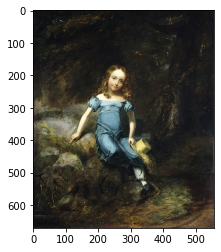

In [219]:
img = get_img(dataPath, p, 0)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

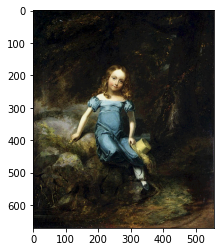

In [220]:
img_quantized = img // 20
img_quantized *= 20
plt.imshow(img_quantized)

In [221]:
domCol = bincount_app(img_quantized)

In [227]:
np.array(domCol, "uint8")

array([20, 20, 20], dtype=uint8)

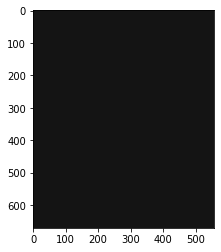

In [223]:
colImg = np.ones_like(img) * domCol
plt.imshow(colImg)

Sent embedding stuff below:

In [ ]:
# sentences = ['This framework generates embeddings for each input sentence',
#     'Sentences are passed as a list of string.', 
#     'The quick brown fox jumps over the lazy dog.']
# sentence_embeddings = model.encode(sentences)
for title in data["Title"].tolist():
    sentence_embeddings = model.encode(title)

    print("Sentence embeddings:")
    print(sentence_embeddings.shape)